In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from bayesreconpy.reconc_buis import reconc_buis

from utils import import_raw_data, make_dataloaders
from validation import quantile_loss, validate_local_fn
from reconciliation import (
    make_imputed_data,
    aggregate_data, 
    temporal_recon_ts,
    valid_sectional_reconciliation,
    matrix_from_columns
)

from forecasters import gp
from tweediegp.intermittent_gp import intermittentGP


In [1]:
# remove large demand spikes (across all datasets) 
def remove_spikes(sales, in_stock, threshold = 4.): 
# remove all data for times where they globally get over the threshold 
    in_stock = in_stock.iloc[:,:sales.shape[1]].copy()
    in_stock.iloc[:,(np.nanmean(np.where(in_stock, sales, np.nan), axis=0) > threshold)] = False 
    return in_stock 

In [5]:
sales, in_stock, master = import_raw_data()
in_stock = remove_spikes(sales, in_stock, 4.)
sales_imputed, is_imputed, _ = make_imputed_data(sales, in_stock, hot_start = True)

100%|██████████| 599/599 [03:01<00:00,  3.30it/s]


<Axes: >

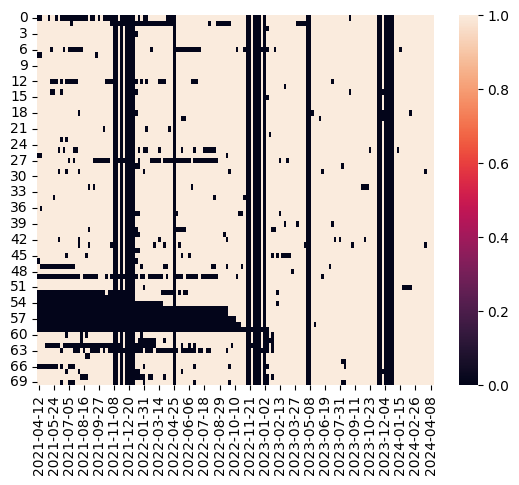

In [6]:
A = matrix_from_columns(master, 2)
sales_aggr, in_stock_aggr, master_aggr = aggregate_data(sales_imputed, in_stock, master,
                                                        A, is_imputed, 0.1)
sns.heatmap(in_stock_aggr)

In [8]:
# this function returns values from the empirical distribution
def empirical(train_y, train_x, test_x):
    return train_y[torch.randint(0, len(train_y), (10000, len(test_x)))]
def recon_empirical(train_y, observed, h):
    recon_samples, _ = temporal_recon_ts(empirical, train_y, observed, 3)
    return torch.tensor(recon_samples[:,:h])


def negbingp(train_y, train_x, test_x):
    return gp(train_y, train_x, test_x, likelihood="negbin")
def recon_negbingp(train_y, observed, h):
    recon_samples, _ = temporal_recon_ts(negbingp, train_y, observed, 3)
    return torch.tensor(recon_samples[:,:h])

def exactgp(train_y, train_x, test_x):
    return gp(train_y, train_x, test_x, likelihood="gaussian")
def recon_exactgp(train_y, observed, h):
    recon_samples, _ = temporal_recon_ts(exactgp, train_y, observed, 3)
    return torch.tensor(recon_samples[:,:h])

def autogp(train_y, train_x, test_x):
    return gp(train_y, train_x, test_x, likelihood="gaussian")
def recon_autogp(train_y, observed, h):
    if torch.all(train_y[observed] > 0):
        fn = exactgp
    else:
        fn = negbingp
    recon_samples, _ = temporal_recon_ts(fn, train_y, observed, 3)
    return torch.tensor(recon_samples[:,:h])

#valid_sectional_reconciliation((sales, in_stock, master, imputed_idx), recon_negbingp, recon_exactgp, A)

In [ ]:
valid_sectional_

In [9]:
experiments = []

for fn_aggr in ["exact"]:#["negbin", "exact", "auto"]:
    for aggr_type in ["zambo"]:
        for prop in [0.1, 0.2]:

            if fn_aggr == "auto":
                fn = recon_autogp
            elif fn_aggr == "negbin":
                fn = recon_negbingp
            elif fn_aggr == "exact":
                fn = recon_exactgp


            if aggr_type in "hier_1":
                A = matrix_from_columns(master, 1)
            elif aggr_type in "hier_2":
                A = matrix_from_columns(master, 2)
            elif aggr_type in "zambo":
                A = pd.read_csv("A_product_same_order_as_sales.csv")
                A = np.array(A.set_index(A.columns[0]))

            if aggr_type == "zambo" and fn_aggr != "exact":
                continue
            
            try:
                results = valid_sectional_reconciliation((sales, in_stock, master, imputed_idx), 
                                                          recon_negbingp, fn, A, prop)
        
                for T in results.keys():
                    experiments.append(
                        pd.Series({
                            "fn":fn_aggr,
                            "aggr":aggr_type,
                            "prop":prop,
                            "QL simple base":results[T]["quantile_loss_simple_base"],
                            "QL simple recon":results[T]["quantile_loss_simple_recon"],
                            "QL cumulative base":results[T]["quantile_loss_cumulative_base"],
                            "QL cumulative recon":results[T]["quantile_loss_cumulative_recon"],
                        })
                    )
            except:
                pass

experiments = pd.DataFrame(experiments)

670it [07:32,  1.48it/s]
670it [07:23,  1.51it/s]
670it [06:54,  1.62it/s]
670it [07:01,  1.59it/s]
670it [06:51,  1.63it/s]
670it [06:43,  1.66it/s]
670it [06:52,  1.62it/s]
670it [06:42,  1.66it/s]
670it [06:45,  1.65it/s]
670it [06:46,  1.65it/s]


In [12]:
experiments.groupby(["fn", "aggr", "prop"], dropna=False).agg(["mean", "std"]).round(3)

QL simple base        QL simple recon         \
                           mean    std            mean    std   
fn    aggr  prop                                                
exact zambo 0.1           1.030  0.030           1.009  0.018   
            0.2           1.032  0.022           1.014  0.014   

                 QL cumulative base        QL cumulative recon         
                               mean    std                mean    std  
fn    aggr  prop                                                       
exact zambo 0.1               1.974  0.131               1.950  0.096  
            0.2               1.993  0.090               1.961  0.075

In [ ]:
experiments2 = []

for fn_aggr in ["auto"]:#["negbin", "exact", "auto"]:
    for aggr_type in ["hier_2"]:
        for prop in [0.1, 0.2]:

            if fn_aggr == "auto":
                fn = recon_autogp
            elif fn_aggr == "negbin":
                fn = recon_negbingp
            elif fn_aggr == "exact":
                fn = recon_exactgp


            if aggr_type in "hier_1":
                A = matrix_from_columns(master, 1)
            elif aggr_type in "hier_2":
                A = matrix_from_columns(master, 2)
            elif aggr_type in "zambo":
                A = pd.read_csv("A_product_same_order_as_sales.csv")
                A = np.array(A.set_index(A.columns[0]))

            if aggr_type == "zambo" and fn_aggr != "exact":
                continue
            
            try:
                results = valid_sectional_reconciliation((sales, in_stock, master, imputed_idx), 
                                                          recon_negbingp, fn, A, prop)
        
                for T in results.keys():
                    experiments2.append(
                        pd.Series({
                            "fn":fn_aggr,
                            "aggr":aggr_type,
                            "prop":prop,
                            "QL simple base":results[T]["quantile_loss_simple_base"],
                            "QL simple recon":results[T]["quantile_loss_simple_recon"],
                            "QL cumulative base":results[T]["quantile_loss_cumulative_base"],
                            "QL cumulative recon":results[T]["quantile_loss_cumulative_recon"],
                        })
                    )
            except:
                pass

experiments2 = pd.DataFrame(experiments2)

669it [08:30,  1.31it/s]
669it [08:11,  1.36it/s]
669it [06:54,  1.61it/s]
669it [07:34,  1.47it/s]
669it [07:14,  1.54it/s]
669it [07:50,  1.42it/s]
669it [07:04,  1.58it/s]
669it [06:34,  1.70it/s]
669it [06:38,  1.68it/s]
18it [00:09,  1.79it/s]

In [ ]:
experiments2.groupby(["fn_aggr", "aggr", "prop"], dropna=False).agg(["mean", "std"])

In [ ]:
experiments = []

for fn_aggr in ["exact", "auto"]:
    for aggr_type in ["hier_1"]:
        for prop in [0.1]:

            if fn_aggr == "auto":
                fn = recon_autogp
            elif fn_aggr == "negbin":
                fn = recon_negbingp
            elif fn_aggr == "exact":
                fn = recon_exactgp


            if aggr_type in "hier_1":
                A = matrix_from_columns(master, 1)
            elif aggr_type in "hier_2":
                A = matrix_from_columns(master, 2)
            elif aggr_type in "zambo":
                A = pd.read_csv("A_product_same_order_as_sales.csv")
                A = np.array(A.set_index(A.columns[0]))

            if aggr_type == "zambo" and fn_aggr != "exact":
                continue
            
            try:
                results = valid_sectional_reconciliation((sales, in_stock, master, imputed_idx), 
                                                          recon_negbingp, fn, A, prop)
        
                for T in results.keys():
                    experiments.append(
                        pd.Series({
                            "fn":fn_aggr,
                            "aggr":aggr_type,
                            "prop":prop,
                            "QL simple base":results[T]["quantile_loss_simple_base"],
                            "QL simple recon":results[T]["quantile_loss_simple_recon"],
                            "QL cumulative base":results[T]["quantile_loss_cumulative_base"],
                            "QL cumulative recon":results[T]["quantile_loss_cumulative_recon"],
                        })
                    )
            except:
                pass

experiments = pd.DataFrame(experiments)

## Material for Zambo

In [ ]:

sales, in_stock, master = import_raw_data()
sales_imputed, in_stock_imputed, imputed_idx, _ = make_imputed_data(sales, in_stock, hot_start = False)

sales_imputed.to_csv("sales_imputed.csv", index=False)
in_stock_imputed.to_csv("in_stock_imputed.csv", index=False)
imputed_idx.to_csv("imputed_idx.csv", index= False)
sns.heatmap(imputed_idx)
plt.title("imputed values")

In [ ]:

# build a hierarchy  starting from an aggregation matrix A
def hierarchical_data(sales, in_stock, master, A, imputed_idx = None, imputed_prop = 0.2):

    # iterate through each value of each aggregation level
    sales_aggr, in_stock_aggr, master_aggr = [], [], []
    for a in A:
        a = a.astype(bool)
        ts = sales[a].sum(axis=0)
        sales_aggr.append(ts)

        # select the aggregated observed values
        if imputed_idx is not None:
            obs = np.logical_or((in_stock & ~imputed_idx)[a].all(), 
                                 (sales[a]*imputed_idx[a]).sum(axis=0) < imputed_prop*ts)
        else:
            obs = in_stock[a].all(axis=0)
        in_stock_aggr.append(obs)

        # extract master features, when unique across bottoms
        uniques = [master[a][col].unique() for col in master.columns]
        feats = pd.Series([uniques[i].item() if len(uniques[i]) == 1 else -1 for i in range(len(uniques))], index=master.columns)                     
        master_aggr.append(feats)

    # build the dataframes and return them
    sales_aggr = pd.DataFrame(sales_aggr)
    in_stock_aggr = pd.DataFrame(in_stock_aggr)
    master_aggr = pd.DataFrame(master_aggr)
    return sales_aggr, in_stock_aggr, master_aggr


In [ ]:
A = pd.read_csv("A_product_same_order_as_sales.csv")
A = np.array(A.set_index(A.columns[0]))

datasets_aggr = hierarchical_data(sales_imputed,in_stock_imputed,master,A,
                                  imputed_idx, 0.25)
sales_aggr, in_stock_aggr, master_aggr = datasets_aggr

sales_aggr.to_csv("sales_aggr.csv", index=False)
in_stock_aggr.to_csv("in_stock_aggr.csv", index=False)
sns.heatmap(in_stock_aggr)

In [ ]:
from tweediegp.exact_gp import exactGP
from tweediegp.intermittent_gp import intermittentGP


def gp(train_y, train_x, test_x):
    # model = exactGP(
    #     kernel=None,
    #     scaling=False,
    #     num_inducing_points=None,
    #     min_iter=50,
    #     max_iter=100,
    #     n_samples=100000
    # )

    model = intermittentGP(
        likelihood="gaussian",
        kernel=None,
        scaling="mean",
        num_inducing_points=None,
        min_iter=50,
        max_iter=100,
        n_samples=100000
    )


    
    for i in range(5):
    # try:
        model.build(train_x, train_y)
        model.fit(train_x, train_y)
        _, samples = model.predict(test_x)
        res = train_y.detach() - model.predict(train_x)[0]
        return torch.round(samples), res
    # except:
    #     pass

    raise ValueError()

In [ ]:
from reconciliation import temporal_aggr
import seaborn as sns

def temporal_recon_ts(fn, train_y, observed, h_recon):
    
    # instanciate inputs, replacing unobsrved with nans
    x = torch.arange(len(train_y) + h_recon)/52
    train_x, test_x = x[:len(train_y)], x[len(train_y):]
    train_x_full = torch.where(observed, train_x, torch.nan)
    train_y_full = torch.where(observed, train_y, torch.nan)     

    # provide base_forecasts
    base_bottom_samples, res_base = fn(
        train_y_full[~torch.isnan(train_y_full)],
        train_x_full[~torch.isnan(train_x_full)], 
        test_x
        )
            
    # generate aggregated forecasts
    train_x_aggr = temporal_aggr(train_x_full, h_recon, "mean")
    train_y_aggr = temporal_aggr(train_y_full, h_recon, "sum")
    base_aggr_samples, _ = fn(
        train_y_aggr[~torch.isnan(train_y_aggr)],
        train_x_aggr[~torch.isnan(train_x_aggr)], 
        temporal_aggr(test_x, h_recon, "mean")
    )

    base_bottom_samples, res_base, base_aggr_samples = (
        base_bottom_samples.detach().numpy(), 
        res_base.detach().numpy(), 
        base_aggr_samples.detach().numpy(),
    )

    # build the hierarchy (aggregated level 1st) and reconcile it
    hier_samples = np.concat((base_aggr_samples, base_bottom_samples), axis=1)
    recon_bottom_samples = reconc_buis(A=np.ones((1,h_recon)),
                                       base_forecasts=[hier_samples[:,j] for j in range(1+h_recon)],
                                       in_type=['samples']*(1+h_recon),
                                       distr='discrete', 
                                       num_samples=hier_samples.shape[0])['bottom_reconciled_samples'].T
    return recon_bottom_samples, base_bottom_samples, res_base


In [ ]:
h_recon=4
q = 5/6
h = 3
assert h_recon >= h

# iterate across different training sets
validation_results = {}
for T in [153, 154, 155, 156, 157]:

    # load the data
    loaders = make_dataloaders(datasets_aggr, T, h, batch_size=1)
    _, _, test_loader, _ = loaders
    
    # initialize the arrays for storing true values and samples
    actuals, base_samples, recon_samples, in_sample_residuals = [], [], [], []

    # iterate over t.s. of the dataset
    for ts in tqdm(test_loader):

        # take the values and reconcile them
        train_y = ts['past_target'].squeeze()
        observed = ts['past_observed_values'].squeeze()
        recon_bottom_samples, _, res_base = temporal_recon_ts(gp, train_y, observed, h_recon)
        res_nans = np.full(len(observed), np.nan)
        res_nans[observed] = res_base

        recon_samples.append(recon_bottom_samples[None,:,:h])
        in_sample_residuals.append(res_nans)

    # stack together previously computed values
    recon_samples, in_sample_residuals = np.vstack(recon_samples), np.vstack(in_sample_residuals)

    np.save(f"samples_{T}.npy", recon_samples.reshape(recon_samples.shape[0], -1))
    np.save(f"residuals_{T}.npy", in_sample_residuals)